In [46]:
# importing data manipulation libraries
import pandas as pd
import numpy as np
# from ydata_profiling import ProfileReport

# importing visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# import ML tools 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# configure notebook for inline plotting
%matplotlib inline

# config pandas to display more than 20 columns
pd.set_option('display.max_columns',250)

# set grid style 
sns.set_style('darkgrid')

In [2]:
# load data from file
data = pd.read_csv('./data/refined_match_data.csv', header=0)

# inspect the dataframe
data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,team_a_xg_prematch,team_b_xg_prematch,total_xg_prematch,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,0.0,0.0,0.0,0.740018,2.456310,2.456310,0.740018,0.740018,1.695140,1.695140,0.740018,0.0,5.0,5.0,0.0,2.0,1.0,1.0,2.0,0.2861,2.5892,-0.955122,0.955122,268.0,282.0,15.0,25.0,282.0,268.0,25.0,15.0
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,0.0,0.0,0.0,1.049030,1.720890,1.720890,1.049030,1.049030,1.720890,1.720890,1.049030,5.0,2.0,2.0,5.0,0.0,1.0,1.0,0.0,0.7766,1.9346,-0.671860,0.671860,230.0,165.0,21.0,16.0,165.0,230.0,16.0,21.0
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,0.0,0.0,0.0,0.990062,0.684593,0.684593,0.990062,0.990062,0.684593,0.684593,0.990062,4.0,5.0,5.0,4.0,0.0,1.0,1.0,0.0,1.6241,1.0403,0.305469,-0.305469,98.0,184.0,23.0,26.0,184.0,98.0,26.0,23.0
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,0.0,0.0,0.0,0.790063,1.123480,1.123480,0.790063,0.790063,1.123480,1.123480,0.790063,5.0,8.0,8.0,5.0,1.0,1.0,1.0,1.0,1.0261,1.6417,-0.333417,0.333417,230.0,184.0,31.0,34.0,184.0,230.0,34.0,31.0
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,0.0,0.0,0.0,1.805230,0.485626,0.485626,1.805230,1.805230,0.485626,0.485626,1.805230,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,2.5279,0.3097,1.319604,-1.319604,234.0,199.0,32.0,22.0,199.0,234.0,22.0,32.0


In [3]:
# drop matches with "incomplete" or "suspended" status
data = data[data['status'] == 'complete']

In [4]:
# check shape of data
data.shape

(6278, 49)

In [5]:
# Get the shape (number of rows and columns) where the 'team_a_xg_prematch' column is equal to 0
data[data['team_a_xg_prematch']==0].shape

(3609, 49)

In [6]:
# Get the shape (number of rows and columns) where the 'team_b_xg_prematch' column is equal to 0
data[data['team_b_xg_prematch']==0].shape

(3609, 49)

In [7]:
# Get the shape (number of rows and columns) where the 'total_xg_prematch' column is equal to 0
data[data['total_xg_prematch']==0].shape

(3603, 49)

In [8]:
# check entries with values == 0
columns_to_drop = ['team_a_xg_prematch', 'team_b_xg_prematch', 'total_xg_prematch']


In [9]:
# drop columns with missing values
data.drop(columns=columns_to_drop, inplace=True)

In [10]:
# inspect the first few rows of data dataframe
data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,0.740018,2.456310,2.456310,0.740018,0.740018,1.695140,1.695140,0.740018,0.0,5.0,5.0,0.0,2.0,1.0,1.0,2.0,0.2861,2.5892,-0.955122,0.955122,268.0,282.0,15.0,25.0,282.0,268.0,25.0,15.0
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,1.049030,1.720890,1.720890,1.049030,1.049030,1.720890,1.720890,1.049030,5.0,2.0,2.0,5.0,0.0,1.0,1.0,0.0,0.7766,1.9346,-0.671860,0.671860,230.0,165.0,21.0,16.0,165.0,230.0,16.0,21.0
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,0.990062,0.684593,0.684593,0.990062,0.990062,0.684593,0.684593,0.990062,4.0,5.0,5.0,4.0,0.0,1.0,1.0,0.0,1.6241,1.0403,0.305469,-0.305469,98.0,184.0,23.0,26.0,184.0,98.0,26.0,23.0
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,0.790063,1.123480,1.123480,0.790063,0.790063,1.123480,1.123480,0.790063,5.0,8.0,8.0,5.0,1.0,1.0,1.0,1.0,1.0261,1.6417,-0.333417,0.333417,230.0,184.0,31.0,34.0,184.0,230.0,34.0,31.0
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,1.805230,0.485626,0.485626,1.805230,1.805230,0.485626,0.485626,1.805230,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,2.5279,0.3097,1.319604,-1.319604,234.0,199.0,32.0,22.0,199.0,234.0,22.0,32.0


In [11]:
def winningTeam(row):
    # Extracting the goal counts for the home and away teams from the row
    homeGoalCount = row['homeGoalCount']
    awayGoalCount = row['awayGoalCount']
    
    # Checking which team won based on the goal counts
    if homeGoalCount > awayGoalCount:
        return 1  # 1 means home team won
    elif awayGoalCount > homeGoalCount:
        return 2  # 2 means away team won
    else:
        return 0  # 0 indicates a draw


In [12]:
# Apply the winningTeam function to each row of the dataframe
data['1x2'] = data.apply(lambda row: winningTeam(row), axis=1)

In [13]:
# check for missing values in the ppg columns
data[data['away_ppg']==0].shape

(0, 47)

In [14]:
data[data['odds_ft_1']==0].shape

(1915, 47)

In [15]:
# check shape of dataframe 
data.shape

(6278, 47)

In [16]:
# drop entries where odds is zero
cleaned_data = data.drop(index=data[data['odds_ft_1']==0].index)

In [17]:
# check size of new dataframe
cleaned_data.shape

(4363, 47)

In [18]:
# inspect column to check that entries with zeros have been dropped
cleaned_data.head()

,id,homeID,awayID,home_name,away_name,date,season,status,homeGoalCount,awayGoalCount,totalGoalCount,team_a_cards_num,team_b_cards_num,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away,1x2
0,2155,150,108,Hull City,Leicester City,2016-08-13,2016/2017,complete,2,1,3,2,2,3.41,3.19,2.39,1.47,0.53,0.740018,2.456310,2.456310,0.740018,0.740018,1.695140,1.695140,0.740018,0.0,5.0,5.0,0.0,2.0,1.0,1.0,2.0,0.2861,2.5892,-0.955122,0.955122,268.0,282.0,15.0,25.0,282.0,268.0,25.0,15.0,1
1,2156,145,154,Burnley,Swansea City,2016-08-13,2016/2017,complete,0,1,1,3,2,2.45,3.22,3.26,1.74,0.74,1.049030,1.720890,1.720890,1.049030,1.049030,1.720890,1.720890,1.049030,5.0,2.0,2.0,5.0,0.0,1.0,1.0,0.0,0.7766,1.9346,-0.671860,0.671860,230.0,165.0,21.0,16.0,165.0,230.0,16.0,21.0,2
2,2157,143,142,Crystal Palace,West Bromwich Albion,2016-08-13,2016/2017,complete,0,1,1,2,2,2.20,3.25,3.80,1.05,0.84,0.990062,0.684593,0.684593,0.990062,0.990062,0.684593,0.684593,0.990062,4.0,5.0,5.0,4.0,0.0,1.0,1.0,0.0,1.6241,1.0403,0.305469,-0.305469,98.0,184.0,23.0,26.0,184.0,98.0,26.0,23.0,2
3,2158,144,92,Everton,Tottenham Hotspur,2016-08-13,2016/2017,complete,1,1,2,0,0,3.13,3.36,2.45,2.26,1.74,0.790063,1.123480,1.123480,0.790063,0.790063,1.123480,1.123480,0.790063,5.0,8.0,8.0,5.0,1.0,1.0,1.0,1.0,1.0261,1.6417,-0.333417,0.333417,230.0,184.0,31.0,34.0,184.0,230.0,34.0,31.0,0
4,2159,147,141,Middlesbrough,Stoke City,2016-08-13,2016/2017,complete,1,1,2,3,5,2.49,3.20,3.21,0.95,0.89,1.805230,0.485626,0.485626,1.805230,1.805230,0.485626,0.485626,1.805230,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,2.5279,0.3097,1.319604,-1.319604,234.0,199.0,32.0,22.0,199.0,234.0,22.0,32.0,0


In [19]:
# get dataframe info
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4363 entries, 0 to 6279
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4363 non-null   int64  
 1   homeID                 4363 non-null   int64  
 2   awayID                 4363 non-null   int64  
 3   home_name              4363 non-null   object 
 4   away_name              4363 non-null   object 
 5   date                   4363 non-null   object 
 6   season                 4363 non-null   object 
 7   status                 4363 non-null   object 
 8   homeGoalCount          4363 non-null   int64  
 9   awayGoalCount          4363 non-null   int64  
 10  totalGoalCount         4363 non-null   int64  
 11  team_a_cards_num       4363 non-null   int64  
 12  team_b_cards_num       4363 non-null   int64  
 13  odds_ft_1              4363 non-null   float64
 14  odds_ft_x              4363 non-null   float64
 15  odds_ft_2

In [21]:
# Define a list of columns to be dropped from the DataFrame
columns_to_drop = ['id', 'homeID', 'awayID', 'home_name', 'away_name', 'date', 'season',
                   'status', 'homeGoalCount', 'awayGoalCount', 'totalGoalCount',
                   'team_a_cards_num', 'team_b_cards_num']

# Drop the specified columns from the DataFrame
cleaned_data = cleaned_data.drop(columns=columns_to_drop)

In [22]:
# inspect cleaned dataset to confirm columns were dropped successfully
cleaned_data.head()

,odds_ft_1,odds_ft_x,odds_ft_2,home_ppg,away_ppg,xG_home,xG_away,xGA_home,xGA_away,npxG_home,npxG_away,npxGA_home,npxGA_away,deep_home,deep_away,deep_allowed_home,deep_allowed_away,scored_home,scored_away,missed_home,missed_away,xpts_home,xpts_away,npxGD_home,npxGD_away,ppda.att_home,ppda.att_away,ppda.def_home,ppda.def_away,ppda_allowed.att_home,ppda_allowed.att_away,ppda_allowed.def_home,ppda_allowed.def_away,1x2
0,3.41,3.19,2.39,1.47,0.53,0.740018,2.456310,2.456310,0.740018,0.740018,1.695140,1.695140,0.740018,0.0,5.0,5.0,0.0,2.0,1.0,1.0,2.0,0.2861,2.5892,-0.955122,0.955122,268.0,282.0,15.0,25.0,282.0,268.0,25.0,15.0,1
1,2.45,3.22,3.26,1.74,0.74,1.049030,1.720890,1.720890,1.049030,1.049030,1.720890,1.720890,1.049030,5.0,2.0,2.0,5.0,0.0,1.0,1.0,0.0,0.7766,1.9346,-0.671860,0.671860,230.0,165.0,21.0,16.0,165.0,230.0,16.0,21.0,2
2,2.20,3.25,3.80,1.05,0.84,0.990062,0.684593,0.684593,0.990062,0.990062,0.684593,0.684593,0.990062,4.0,5.0,5.0,4.0,0.0,1.0,1.0,0.0,1.6241,1.0403,0.305469,-0.305469,98.0,184.0,23.0,26.0,184.0,98.0,26.0,23.0,2
3,3.13,3.36,2.45,2.26,1.74,0.790063,1.123480,1.123480,0.790063,0.790063,1.123480,1.123480,0.790063,5.0,8.0,8.0,5.0,1.0,1.0,1.0,1.0,1.0261,1.6417,-0.333417,0.333417,230.0,184.0,31.0,34.0,184.0,230.0,34.0,31.0,0
4,2.49,3.20,3.21,0.95,0.89,1.805230,0.485626,0.485626,1.805230,1.805230,0.485626,0.485626,1.805230,4.0,4.0,4.0,4.0,1.0,1.0,1.0,1.0,2.5279,0.3097,1.319604,-1.319604,234.0,199.0,32.0,22.0,199.0,234.0,22.0,32.0,0


In [23]:
cleaned_data.columns

Index(['odds_ft_1', 'odds_ft_x', 'odds_ft_2', 'home_ppg', 'away_ppg',
       'xG_home', 'xG_away', 'xGA_home', 'xGA_away', 'npxG_home', 'npxG_away',
       'npxGA_home', 'npxGA_away', 'deep_home', 'deep_away',
       'deep_allowed_home', 'deep_allowed_away', 'scored_home', 'scored_away',
       'missed_home', 'missed_away', 'xpts_home', 'xpts_away', 'npxGD_home',
       'npxGD_away', 'ppda.att_home', 'ppda.att_away', 'ppda.def_home',
       'ppda.def_away', 'ppda_allowed.att_home', 'ppda_allowed.att_away',
       'ppda_allowed.def_home', 'ppda_allowed.def_away', '1x2'],
      dtype='object')

In [25]:
# check for null values
cleaned_data.isnull().sum()

odds_ft_1                  0
odds_ft_x                  0
odds_ft_2                  0
home_ppg                   0
away_ppg                   0
xG_home                  785
xG_away                  785
xGA_home                 785
xGA_away                 785
npxG_home                785
npxG_away                785
npxGA_home               785
npxGA_away               785
deep_home                785
deep_away                785
deep_allowed_home        785
deep_allowed_away        785
scored_home              785
scored_away              785
missed_home              785
missed_away              785
xpts_home                785
xpts_away                785
npxGD_home               785
npxGD_away               785
ppda.att_home            785
ppda.att_away            785
ppda.def_home            785
ppda.def_away            785
ppda_allowed.att_home    785
ppda_allowed.att_away    785
ppda_allowed.def_home    785
ppda_allowed.def_away    785
1x2                        0
dtype: int64

In [26]:
# drop null values
cleaned_data.dropna(inplace=True)

In [27]:
# Separate features (X) and target variable (y)
X = cleaned_data.drop(columns=['1x2'])  # Features
y = cleaned_data['1x2']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the testing set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [28]:
# Standardize the features using StandardScaler
scaler = StandardScaler()

# Fit and transform the training set to standardize its features
X_train = scaler.fit_transform(X_train)

# Transform the testing set using the same scaler to maintain consistency
X_test = scaler.transform(X_test)

# Transform the validation set using the same scaler for consistent scaling
X_val = scaler.transform(X_val)

In [29]:
# Use LabelEncoder to convert the target variable to numeric values
label_encoder = LabelEncoder()

# Fit and transform the training set labels to numeric values
y_train_encoded = label_encoder.fit_transform(y_train)

# Transform the validation and test set labels to numeric values using the same encoder
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
y_train_categorical = to_categorical(y_train_encoded)
y_val_categorical = to_categorical(y_val_encoded)
y_test_categorical = to_categorical(y_test_encoded)

In [30]:
# Define the path to save the best model
model_path = './models/base_model'

In [31]:
# ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [32]:
# Print the shape of the training feature set (X_train)
print('The shape of X_train is: ',X_train.shape)

The shape of X_train is:  (2862, 33)


In [33]:
# Print the shape of the training feature set (y_train_categorical)
print('The shape of y_train_categorical is: ',y_train_categorical.shape)

The shape of y_train_categorical is:  (2862, 3)


In [34]:
# Define an EarlyStopping callback
# - 'monitor' specifies the metric to monitor for improvement, in this case, validation loss.
# - 'patience' determines the number of epochs with no improvement after which training will be stopped.
# - 'restore_best_weights' ensures that the model's weights are restored to the best values when training stops.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [35]:
# LSTM model
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))
# 3 classes, so output layer has 3 units and 'softmax' activation

# Compile the model with 'categorical_crossentropy' loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, validation_data=(X_val, y_val_categorical), callbacks=[checkpoint, early_stopping])

# Evaluate the model on the test set
accuracy = model.evaluate(X_test, y_test_categorical)[1]
print(f"Test Accuracy: {accuracy:.2f}")



Epoch 1/50


90/90 [==============================] - ETA: 0s - loss: 1.0567 - accuracy: 0.4469
Epoch 1: val_accuracy improved from -inf to 0.42458, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 7s 51ms/step - loss: 1.0567 - accuracy: 0.4469 - val_loss: 1.0314 - val_accuracy: 0.4246
Epoch 2/50
89/90 [============================>.] - ETA: 0s - loss: 1.0528 - accuracy: 0.4501
Epoch 2: val_accuracy improved from 0.42458 to 0.43017, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 42ms/step - loss: 1.0521 - accuracy: 0.4511 - val_loss: 1.0316 - val_accuracy: 0.4302
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 1.0440 - accuracy: 0.4535
Epoch 3: val_accuracy did not improve from 0.43017
90/90 [==============================] - 2s 22ms/step - loss: 1.0440 - accuracy: 0.4535 - val_loss: 1.0215 - val_accuracy: 0.4246
Epoch 4/50
90/90 [==============================] - ETA: 0s - loss: 1.0321 - accuracy: 0.4532
Epoch 4: val_accuracy did not improve from 0.43017
90/90 [==============================] - 2s 22ms/step - loss: 1.0321 - accuracy: 0.4532 - val_loss: 1.0198 - val_accuracy: 0.4274
Epoch 5/50
90/90 [==============================] - ETA: 0s - loss: 1.0154 - accuracy: 0.4598
Epoch 5: val_accuracy did not improve from 0.43017
90/90 [==============================] - 2s 22ms/step - loss: 1.0154 - accuracy: 0.4598 - val_loss: 0.9926 - val_accuracy: 0.4274
Epoch 6/50
88/90 [===========================

INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 42ms/step - loss: 0.9985 - accuracy: 0.4794 - val_loss: 1.0023 - val_accuracy: 0.4497
Epoch 7/50
90/90 [==============================] - ETA: 0s - loss: 0.9630 - accuracy: 0.5035
Epoch 7: val_accuracy improved from 0.44972 to 0.48603, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 42ms/step - loss: 0.9630 - accuracy: 0.5035 - val_loss: 0.9470 - val_accuracy: 0.4860
Epoch 8/50
90/90 [==============================] - ETA: 0s - loss: 0.9437 - accuracy: 0.5122
Epoch 8: val_accuracy improved from 0.48603 to 0.52793, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 44ms/step - loss: 0.9437 - accuracy: 0.5122 - val_loss: 0.9025 - val_accuracy: 0.5279
Epoch 9/50
90/90 [==============================] - ETA: 0s - loss: 0.9065 - accuracy: 0.5294
Epoch 9: val_accuracy improved from 0.52793 to 0.54190, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 46ms/step - loss: 0.9065 - accuracy: 0.5294 - val_loss: 0.8471 - val_accuracy: 0.5419
Epoch 10/50
90/90 [==============================] - ETA: 0s - loss: 0.8608 - accuracy: 0.5580
Epoch 10: val_accuracy improved from 0.54190 to 0.55866, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 44ms/step - loss: 0.8608 - accuracy: 0.5580 - val_loss: 0.8299 - val_accuracy: 0.5587
Epoch 11/50
89/90 [============================>.] - ETA: 0s - loss: 0.8244 - accuracy: 0.5639
Epoch 11: val_accuracy did not improve from 0.55866
90/90 [==============================] - 2s 23ms/step - loss: 0.8247 - accuracy: 0.5636 - val_loss: 0.8353 - val_accuracy: 0.5559
Epoch 12/50
90/90 [==============================] - ETA: 0s - loss: 0.7938 - accuracy: 0.5894
Epoch 12: val_accuracy improved from 0.55866 to 0.60894, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 43ms/step - loss: 0.7938 - accuracy: 0.5894 - val_loss: 0.7510 - val_accuracy: 0.6089
Epoch 13/50
90/90 [==============================] - ETA: 0s - loss: 0.7368 - accuracy: 0.6293
Epoch 13: val_accuracy improved from 0.60894 to 0.66480, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 44ms/step - loss: 0.7368 - accuracy: 0.6293 - val_loss: 0.7490 - val_accuracy: 0.6648
Epoch 14/50
90/90 [==============================] - ETA: 0s - loss: 0.6792 - accuracy: 0.6744
Epoch 14: val_accuracy improved from 0.66480 to 0.72626, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 47ms/step - loss: 0.6792 - accuracy: 0.6744 - val_loss: 0.6392 - val_accuracy: 0.7263
Epoch 15/50
90/90 [==============================] - ETA: 0s - loss: 0.6135 - accuracy: 0.7114
Epoch 15: val_accuracy did not improve from 0.72626
90/90 [==============================] - 2s 23ms/step - loss: 0.6135 - accuracy: 0.7114 - val_loss: 0.5992 - val_accuracy: 0.7039
Epoch 16/50
89/90 [============================>.] - ETA: 0s - loss: 0.5730 - accuracy: 0.7384
Epoch 16: val_accuracy improved from 0.72626 to 0.76816, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 43ms/step - loss: 0.5719 - accuracy: 0.7393 - val_loss: 0.5263 - val_accuracy: 0.7682
Epoch 17/50
90/90 [==============================] - ETA: 0s - loss: 0.5350 - accuracy: 0.7498
Epoch 17: val_accuracy did not improve from 0.76816
90/90 [==============================] - 2s 23ms/step - loss: 0.5350 - accuracy: 0.7498 - val_loss: 0.6359 - val_accuracy: 0.7095
Epoch 18/50
89/90 [============================>.] - ETA: 0s - loss: 0.5144 - accuracy: 0.7718
Epoch 18: val_accuracy improved from 0.76816 to 0.80447, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 42ms/step - loss: 0.5137 - accuracy: 0.7725 - val_loss: 0.4824 - val_accuracy: 0.8045
Epoch 19/50
88/90 [============================>.] - ETA: 0s - loss: 0.4530 - accuracy: 0.8004
Epoch 19: val_accuracy improved from 0.80447 to 0.80726, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 43ms/step - loss: 0.4539 - accuracy: 0.7994 - val_loss: 0.4217 - val_accuracy: 0.8073
Epoch 20/50
90/90 [==============================] - ETA: 0s - loss: 0.4093 - accuracy: 0.8225
Epoch 20: val_accuracy improved from 0.80726 to 0.81844, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 42ms/step - loss: 0.4093 - accuracy: 0.8225 - val_loss: 0.3756 - val_accuracy: 0.8184
Epoch 21/50
89/90 [============================>.] - ETA: 0s - loss: 0.4271 - accuracy: 0.8188
Epoch 21: val_accuracy improved from 0.81844 to 0.85475, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 5s 50ms/step - loss: 0.4274 - accuracy: 0.8190 - val_loss: 0.3628 - val_accuracy: 0.8547
Epoch 22/50
90/90 [==============================] - ETA: 0s - loss: 0.3843 - accuracy: 0.8428
Epoch 22: val_accuracy did not improve from 0.85475
90/90 [==============================] - 2s 27ms/step - loss: 0.3843 - accuracy: 0.8428 - val_loss: 0.3821 - val_accuracy: 0.8408
Epoch 23/50
90/90 [==============================] - ETA: 0s - loss: 0.3404 - accuracy: 0.8564
Epoch 23: val_accuracy improved from 0.85475 to 0.86872, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 46ms/step - loss: 0.3404 - accuracy: 0.8564 - val_loss: 0.3190 - val_accuracy: 0.8687
Epoch 24/50
90/90 [==============================] - ETA: 0s - loss: 0.3191 - accuracy: 0.8742
Epoch 24: val_accuracy did not improve from 0.86872
90/90 [==============================] - 2s 24ms/step - loss: 0.3191 - accuracy: 0.8742 - val_loss: 0.3102 - val_accuracy: 0.8687
Epoch 25/50
88/90 [============================>.] - ETA: 0s - loss: 0.2882 - accuracy: 0.8803
Epoch 25: val_accuracy did not improve from 0.86872
90/90 [==============================] - 2s 23ms/step - loss: 0.2877 - accuracy: 0.8802 - val_loss: 0.3542 - val_accuracy: 0.8492
Epoch 26/50
90/90 [==============================] - ETA: 0s - loss: 0.2475 - accuracy: 0.9015
Epoch 26: val_accuracy improved from 0.86872 to 0.92179, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 42ms/step - loss: 0.2475 - accuracy: 0.9015 - val_loss: 0.2179 - val_accuracy: 0.9218
Epoch 27/50
88/90 [============================>.] - ETA: 0s - loss: 0.2204 - accuracy: 0.9094
Epoch 27: val_accuracy did not improve from 0.92179
90/90 [==============================] - 2s 23ms/step - loss: 0.2200 - accuracy: 0.9099 - val_loss: 0.2287 - val_accuracy: 0.9106
Epoch 28/50
88/90 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9244
Epoch 28: val_accuracy did not improve from 0.92179
90/90 [==============================] - 2s 23ms/step - loss: 0.1951 - accuracy: 0.9245 - val_loss: 0.2706 - val_accuracy: 0.9022
Epoch 29/50
89/90 [============================>.] - ETA: 0s - loss: 0.1992 - accuracy: 0.9259
Epoch 29: val_accuracy did not improve from 0.92179
90/90 [==============================] - 2s 23ms/step - loss: 0.1991 - accuracy: 0.9259 - val_loss: 0.2404 - val_accuracy: 0.9078
Epoch 30/50
90/90 [====================

INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 42ms/step - loss: 0.1772 - accuracy: 0.9329 - val_loss: 0.1532 - val_accuracy: 0.9413
Epoch 31/50
89/90 [============================>.] - ETA: 0s - loss: 0.1037 - accuracy: 0.9603
Epoch 31: val_accuracy did not improve from 0.94134
90/90 [==============================] - 2s 24ms/step - loss: 0.1038 - accuracy: 0.9602 - val_loss: 0.2922 - val_accuracy: 0.8994
Epoch 32/50
90/90 [==============================] - ETA: 0s - loss: 0.1690 - accuracy: 0.9364
Epoch 32: val_accuracy did not improve from 0.94134
90/90 [==============================] - 2s 23ms/step - loss: 0.1690 - accuracy: 0.9364 - val_loss: 0.1786 - val_accuracy: 0.9274
Epoch 33/50
89/90 [============================>.] - ETA: 0s - loss: 0.1359 - accuracy: 0.9480
Epoch 33: val_accuracy improved from 0.94134 to 0.96089, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 43ms/step - loss: 0.1358 - accuracy: 0.9479 - val_loss: 0.1128 - val_accuracy: 0.9609
Epoch 34/50
88/90 [============================>.] - ETA: 0s - loss: 0.0672 - accuracy: 0.9737
Epoch 34: val_accuracy did not improve from 0.96089
90/90 [==============================] - 2s 25ms/step - loss: 0.0668 - accuracy: 0.9738 - val_loss: 0.1226 - val_accuracy: 0.9441
Epoch 35/50
88/90 [============================>.] - ETA: 0s - loss: 0.0788 - accuracy: 0.9705
Epoch 35: val_accuracy did not improve from 0.96089
90/90 [==============================] - 2s 24ms/step - loss: 0.0792 - accuracy: 0.9700 - val_loss: 0.0976 - val_accuracy: 0.9609
Epoch 36/50
90/90 [==============================] - ETA: 0s - loss: 0.0807 - accuracy: 0.9689
Epoch 36: val_accuracy did not improve from 0.96089
90/90 [==============================] - 2s 24ms/step - loss: 0.0807 - accuracy: 0.9689 - val_loss: 0.1043 - val_accuracy: 0.9525
Epoch 37/50
90/90 [====================

INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 47ms/step - loss: 0.0417 - accuracy: 0.9843 - val_loss: 0.0373 - val_accuracy: 0.9916
Epoch 38/50
88/90 [============================>.] - ETA: 0s - loss: 0.0290 - accuracy: 0.9886
Epoch 38: val_accuracy did not improve from 0.99162
90/90 [==============================] - 2s 24ms/step - loss: 0.0290 - accuracy: 0.9888 - val_loss: 0.0604 - val_accuracy: 0.9804
Epoch 39/50
90/90 [==============================] - ETA: 0s - loss: 0.0254 - accuracy: 0.9909
Epoch 39: val_accuracy did not improve from 0.99162
90/90 [==============================] - 2s 22ms/step - loss: 0.0254 - accuracy: 0.9909 - val_loss: 0.0292 - val_accuracy: 0.9832
Epoch 40/50
90/90 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9839
Epoch 40: val_accuracy did not improve from 0.99162
90/90 [==============================] - 2s 22ms/step - loss: 0.0476 - accuracy: 0.9839 - val_loss: 0.0683 - val_accuracy: 0.9804
Epoch 41/50
90/90 [====================

INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 44ms/step - loss: 6.6331e-04 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 0.9972
Epoch 45/50
90/90 [==============================] - ETA: 0s - loss: 1.8997e-04 - accuracy: 1.0000
Epoch 45: val_accuracy improved from 0.99721 to 1.00000, saving model to ./models\base_model
INFO:tensorflow:Assets written to: ./models\base_model\assets


INFO:tensorflow:Assets written to: ./models\base_model\assets


90/90 [==============================] - 4s 43ms/step - loss: 1.8997e-04 - accuracy: 1.0000 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 46/50
88/90 [============================>.] - ETA: 0s - loss: 7.5606e-05 - accuracy: 1.0000
Epoch 46: val_accuracy did not improve from 1.00000
90/90 [==============================] - 2s 25ms/step - loss: 7.7113e-05 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 47/50
90/90 [==============================] - ETA: 0s - loss: 5.5846e-05 - accuracy: 1.0000
Epoch 47: val_accuracy did not improve from 1.00000
90/90 [==============================] - 2s 26ms/step - loss: 5.5846e-05 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 48/50
88/90 [============================>.] - ETA: 0s - loss: 4.7966e-05 - accuracy: 1.0000
Epoch 48: val_accuracy did not improve from 1.00000
90/90 [==============================] - 2s 24ms/step - loss: 4.7327e-05 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 49/50

In [36]:
# Evaluate the model on the test set
accuracy = model.evaluate(X_test, y_test_categorical)[1]
print(f"Test Accuracy: {accuracy:.2f}")

12/12 [==============================] - 0s 11ms/step - loss: 0.0134 - accuracy: 0.9972
Test Accuracy: 1.00


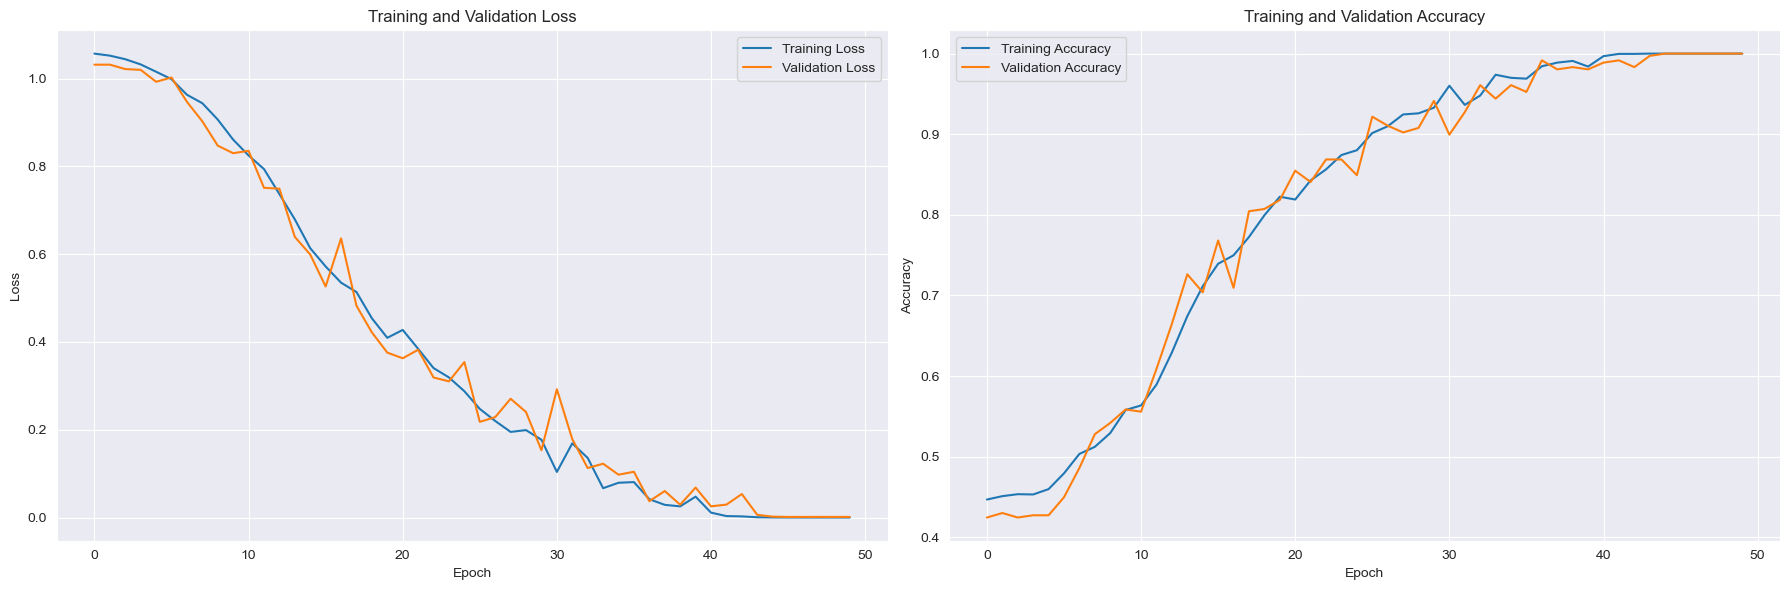

In [41]:
def plot_training_history(history, lr=None, model_name=None):
    # Plot training and validation loss
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    if lr is not None and 'lr' in history.params:
        # Plot learning rate
        plt.figure(figsize=(6, 6))
        plt.plot(history.history['lr'], label='Learning Rate', color='red')
        plt.title('Learning Rate')
        plt.xlabel('Epoch')
        plt.ylabel('LR')
        plt.legend()

    if model_name is not None:
        save_path = os.path.join('./plots/', model_name)
        plt.savefig(save_path)

    plt.tight_layout()
    plt.show()

# Plot training history using plot_training_history function
plot_training_history(history)


12/12 [==============================] - 0s 10ms/step


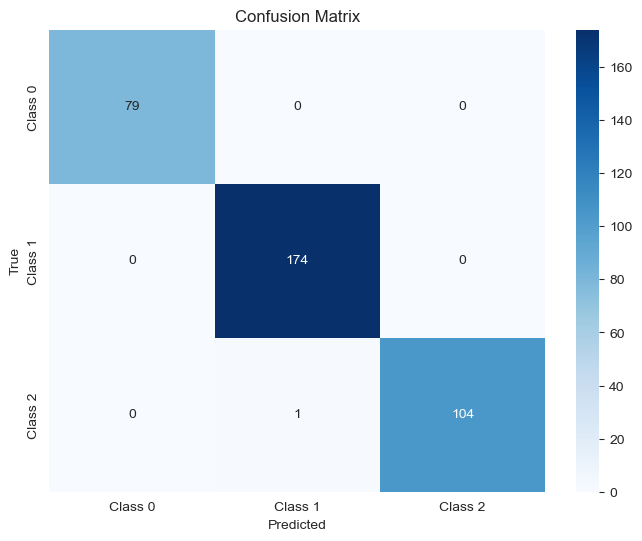

In [44]:
# Evaluate the model on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)



In [ ]:
# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2'],
            yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [47]:
# Calculate precision, recall, and f1 score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

In [51]:
# Create lists for labels and corresponding scores
labels = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1]


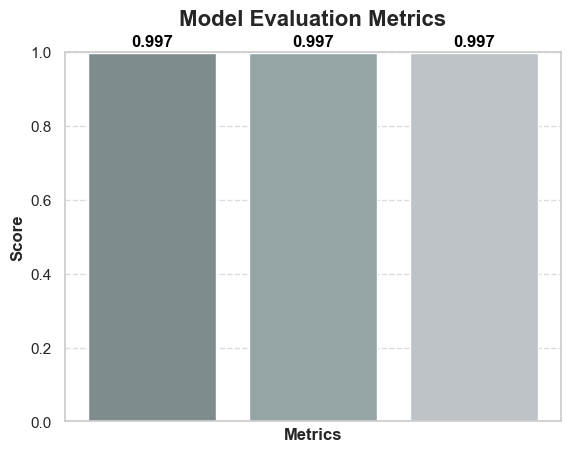

In [57]:
# Set a color palette for the bars (neutral colors)
colors = ['#7f8c8d', '#95a5a6', '#bdc3c7']

# Plotting the bar chart 
fig, ax = plt.subplots()
bars = ax.bar(labels, scores, color=colors)

# Adding data values above the bars with adjusted positioning
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, round(yval, 3), ha='center', va='bottom', color='black', fontweight='bold')

# Adding title and labels
plt.title('Model Evaluation Metrics', fontsize=16, fontweight='bold', y=1.05)  # Adjusted y position for title
plt.xlabel('Metrics', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')

# Adjusting y-axis limits and grid
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Removing x-axis ticks
plt.xticks([])

# Display the plot
plt.show()